## TODO List

- 季/月份/小時 (representative seasons/months/hours of each type of crime)
 - 
- 跨年/州
- 多變量分析 (偽prediction)


# FBI Crime Data Analysis

### Yu-Heng Lei (yuhengl1), Bo-Cheng Lin (bochengl), Xiaoyu Qiu (xiaoyuq)

## Motivation
Emerging crime incidents have raised awareness of
personnel security. Therefore, understanding factors and their
relationship with crime incidents could be useful for predicting
crimes. Security agencies may leverage this analysis to influence
decision making in order to reduce crime rates in the future. 

#TODO: More introduction and motivation

## Technologies and Libraries 



### Data Processing

##### Pandas and Numpy
We’ll firstly use packages like Numpy and Pandas to preprocess the data and establish relationship between tables and data frames.

##### Scikit-learn



### Data Visualization

We will use Matplotlib and Seaborn to help us convey the idea and trends underlying the data.
Scikit-learn could be used to build prediction models.

##### Matplotlib


##### Seaborn



In [1]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Data Collection and Transformation
Our main data sources include FBI Crime Data Explorer API
and National Incident-Based Reporting System (NIBRS). Data formats are
JSON and CSV, respectively. 

You can find the FBI crime data and APIs here:<br>
1. FBI crime data explorer. https://crime-data-explorer.fr.cloud.gov/
2. FBI NIBRS data system. https://crime-data-explorer.fr.cloud.gov/downloads-and-docs

Following the collection of the data, there are 43 tables for a specific state-year combination that needs to be transform into useful format. 
We will first establish the relationships between tables,
such as mapping offender id to offences, motivations to incidents,
etc.

The following cell is used to build up the dataframes we need. Note that I group dfs with obvious relationship between them, there could still be some potential relevance between different groups.

In [2]:
# Note that one incident could have up to 10 offense record
incidentDF = pd.read_csv("PA-2016/nibrs_incident.csv")
offenseDF = pd.read_csv("PA-2016/nibrs_offense.csv")
offenseTypeDF = pd.read_csv("PA-2016/nibrs_offense_type.csv")

# For relationship analysis
victimDF = pd.read_csv("PA-2016/nibrs_victim.csv")
offenderDF = pd.read_csv("PA-2016/nibrs_offender.csv")
victimTypeDF = pd.read_csv("PA-2016/nibrs_victim_type.csv")
ethnicityDF = pd.read_csv("PA-2016/nibrs_ethnicity.csv")
relationshipDF = pd.read_csv("PA-2016/nibrs_relationship.csv")
victimOffenderRelDF = pd.read_csv("PA-2016/nibrs_victim_offender_rel.csv")
ageDF = pd.read_csv("PA-2016/nibrs_age.csv")
locationTable = pd.read_csv("PA-2016/nibrs_location_type.csv")

# Criminal acts
criminalActDF = pd.read_csv("PA-2016/nibrs_criminal_act.csv")
criminalActTypeDF = pd.read_csv("PA-2016/nibrs_criminal_act_type.csv")

# bias of the offense
biasMotivationDF = pd.read_csv("PA-2016/nibrs_bias_motivation.csv")
biasListDF = pd.read_csv("PA-2016/nibrs_bias_list.csv")



## Exploratory Data Analysis and Modeling
With the transformed criminal data, we will make exploratory data analysis (histogram/scatter
plot/basic statistics) to determine the dominant types of features. On
the basis of these features, we could train base models to predict the
possible features of the offender(race, age, sex, relationship with
victim) given resolved incidents using ML algorithm (LR, DT, NN, SVM,
etc.) and select the best model with validation data, and set it as
the base model.


In [3]:
# Helper function for plotting sns.countplot at a fixed size given df and col 
def countPlot(df, col, dpi = 100):
    plt.figure(figsize=(8,6), dpi=dpi)
    sns.countplot(y = df[col], order = df[col].value_counts().index)

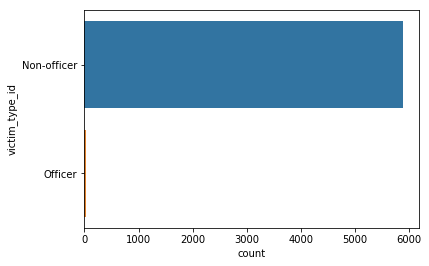

In [4]:
cleanedVictimDF = victimDF.drop(labels=["outside_agency_id",  "agency_data_year", "ff_line_number"], axis=1)
officerDF = cleanedVictimDF[cleanedVictimDF["victim_type_id"] == 5]
nonOfficerDF = cleanedVictimDF[cleanedVictimDF["victim_type_id"] != 5]
count = cleanedVictimDF["victim_type_id"] == 5

# plot out the count of non-officer and officer victims
count[count == False] = "Non-officer"
count[count == True]  = "Officer"
sns.countplot(y = count)

In [11]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
# Replace a col with a specified mapping dict.
locationMapping = dict(zip(locationTable["location_id"], locationTable["location_name"]))
offenseTypeMapping = dict(zip(offenseTypeDF["offense_type_id"], offenseTypeDF["offense_name"]))
victimTypeMapping = dict(zip(victimTypeDF["victim_type_id"], victimTypeDF["victim_type_name"]))
relationshipMapping = dict(zip(relationshipDF["relationship_id"], relationshipDF["relationship_name"]))
criminalActTypeMapping = dict(zip(criminalActTypeDF["criminal_act_id"], criminalActTypeDF["criminal_act_name"]))


{0: 'Not Specified',
 1: 'Air/Bus/Train Terminal',
 2: 'Bank/Savings and Loan',
 3: 'Bar/Nightclub',
 4: 'Church Synagogue/Temple',
 5: 'Commercial/Office Building',
 6: 'Construction Site',
 7: 'Convenience Store',
 8: 'Department/Discount Store',
 10: 'Field/Woods',
 11: 'Government/Public Building',
 12: 'Grocery/Supermarket',
 13: 'Highway/Road/Ally',
 14: 'Hotel/Motel/Etc.',
 15: 'Jail/Prison',
 16: 'Lake/Waterway',
 17: 'Liquor Store',
 18: 'Parking Lot/Garage',
 19: 'Rental Stor. Facil.',
 20: 'Residence/Home',
 21: 'Restaurant',
 22: 'School/College',
 23: 'Service/Gas Station',
 24: 'Specialty Store',
 25: 'Other/Unknown',
 26: 'Abandoned/Condemned Structure',
 27: 'Amusement Park',
 28: 'Arena/Stadium/Fairgrounds/Coliseum',
 29: 'ATM Separate from Bank',
 30: 'Auto Dealership New/Used',
 31: 'Camp/Campground',
 32: 'Daycare Facility',
 33: 'Dock/Wharf/Freight/Modal Terminal',
 34: 'Farm Facility',
 35: 'Gambling Facility/Casino/Race Track',
 36: 'Industrial Site',
 37: 'Milit

In [6]:
offenseCriminalJoined = offenseDF.merge(right=criminalActDF, how="inner", on="offense_id")
offenseCriminalJoined.head()

,offense_id,incident_id,offense_type_id,attempt_complete_flag,location_id,num_premises_entered,method_entry_code,ff_line_number,criminal_act_id
0,91124972,83457473,35,C,13,NaN,NaN,NaN,8
1,92509421,84661377,35,C,20,NaN,NaN,NaN,6
2,93031330,85116218,16,C,38,NaN,NaN,NaN,8
3,93031331,85116218,35,C,38,NaN,NaN,NaN,6
4,94576424,86471112,16,C,7,NaN,NaN,NaN,6


   offense_id  incident_id  offense_type_id attempt_complete_flag  \
0    91124963     83457465               47                     C   
1    91124972     83457473               35                     C   
2    91618994     83886692               51                     C   
3    92509421     84661377               35                     C   
4    92508047     84661375               51                     C   

   location_id  num_premises_entered method_entry_code  ff_line_number  
0           20                   NaN               NaN             NaN  
1           13                   NaN               NaN             NaN  
2           18                   NaN               NaN             NaN  
3           20                   NaN               NaN             NaN  
4           20                   NaN               NaN             NaN  
   offense_id  incident_id            offense_type_id attempt_complete_flag  \
0    91124963     83457465        Theft From Building               

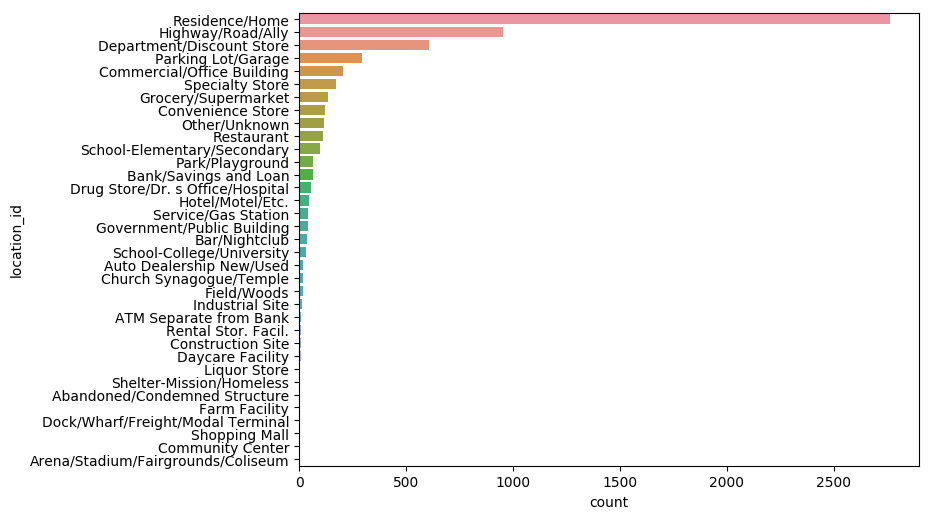

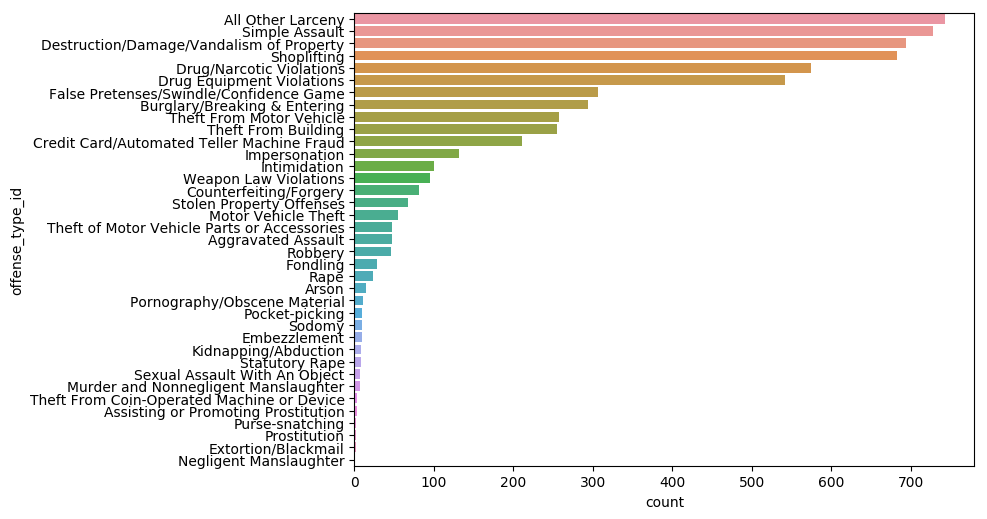

In [10]:
print(offenseDF.head())
remappedOffenseDF = offenseDF.replace({"location_id": locationMapping, "offense_type_id": offenseTypeMapping})
countPlot(remappedOffenseDF, "location_id")
countPlot(remappedOffenseDF, "offense_type_id")
print(remappedOffenseDF.head())

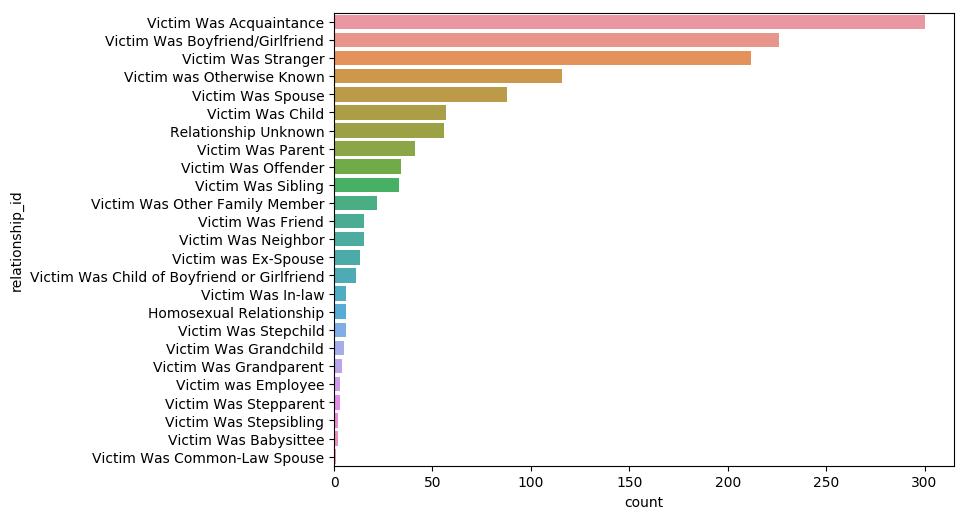

In [8]:
remappedRelDF = victimOffenderRelDF.replace({"relationship_id": relationshipMapping})
countPlot(remappedRelDF, "relationship_id")